In [1]:
import numpy as np

from utils.loadData import loadData
from lstm.preprocessing import prepareTestSet, getDatasets, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExample
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadData()

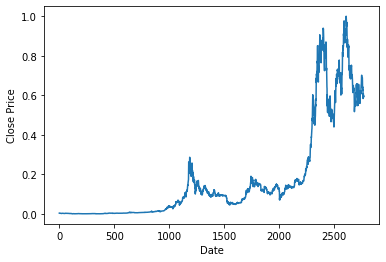

In [3]:
features = np.array(df["Close"]).reshape(-1, 1)
normalized_data, scaler = normalizeAtOnce(features)
show_data_simple(normalized_data)

2022-04-20 12:04:38.326935: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


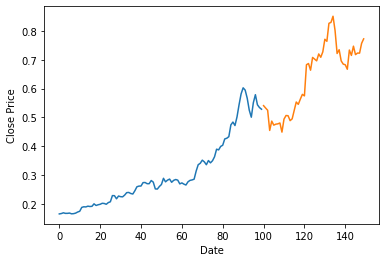

Input shape: (128, 100, 1)
Target shape: (128, 1)


In [4]:
config = {
    "past": 100, # try 10, 50, 100, 300
    "future": 50, # try 5, 50, 100
    "batch_size": 128, # large batches allow faster training
    "epochs": 10,
}

dataset_train, dataset_val, x_test, y_test = getDatasets(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [5]:
model = getModel(inputs, config["future"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
Total params: 126,250
Trainable params: 126,250
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.0040 - rmse: 0.0631
Epoch 1: val_loss improved from inf to 0.16354, saving model to checkpoints/model_checkpoint.h5
17/17 [==============================] - 8s 292ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.1635 - val_rmse: 0.4044
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.0060 - rmse: 0.0776
Epoch 2: val_loss did not improve from 0.16354
17/17 [==============================] - 4s 259ms/step - loss: 0.0060 - rmse: 0.0776 - val_loss: 0.3067 - val_rmse: 0.5538
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.0015 - rmse: 0.0387
Epoch 3: val_loss improved from 0.16354 to 0.07657, saving model to checkpoints/model_checkpoint.h5
17/17 [==============================] - 5s 312ms/step - loss: 0.0015 - rmse: 0.0387 - val_loss: 0.0766 - val_rmse: 0.2767
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.0015 - rmse: 0.0392
Epoch 4: val_loss improved f

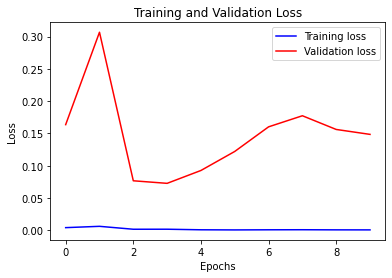

In [6]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [8]:
x, y = prepareTestSet(x_test, y_test, config["past"], config["future"])

In [9]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 1s 1s/step - loss: 0.0365 - rmse: 0.1912
---- TEST RESULTS ----
MSE loss - 0.03654557839035988
RMSE - 0.19116899371147156


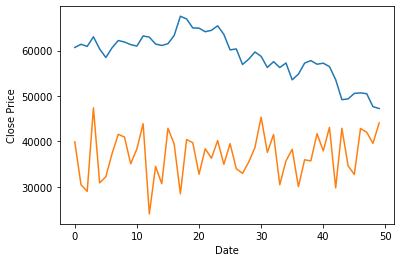

In [10]:
showRegressionExample(x[0], y[0], model, scaler)

In [11]:
# do grid search on past/future
# compare a gazilion of models
# are my labels X and Y really doing what they are supposed to? hmm check